##loading data

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from pathlib import Path
from numpy import asarray
from numpy import savez_compressed
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
data_path = 'drive/MyDrive/Summer_internships/Transfert/Datasets/VIS-TH-8bits'

###helper functions for loading data

In [ ]:
#load & return the compressed data
def load_data(p_tr, p_ts):
  x = np.load(p_tr)
  y = np.load(p_ts)
  x_src, x_dest = x['arr_0'], x['arr_1']
  y_src, y_dest = y['arr_0'], y['arr_1']
  return [x_src, x_dest], [y_src, y_dest]

In [ ]:
#get all dirs and subdirs paths
def get_all_paths(src_dir):
  paths = [x for x in os.listdir(src_dir)]
  paths.remove('metadata.xlsx')
  return paths

In [ ]:
def add_domains(path, paths):
  src = [ os.path.join(path, i, 'TH') for i in paths]
  dest = [ os.path.join(path, i, 'VIS') for i in paths]
  return src, dest

In [ ]:
#concatente VIS and TH images names with their corresponding paths
def get_images(src, dest):
  src_im = []
  dest_im = []
  for x in src:
    for i in os.listdir(x):
      #skipping dark images
      if i.find('20_LD') != -1:
        continue
      else:
        src_im.append(os.path.join(x, i))
  for y in dest:
    for j in os.listdir(y):
      #skipping dark images
      if j.find('20_LD') != -1:
        continue
      else:
        dest_im.append(os.path.join(y, j))
  return src_im, dest_im

In [ ]:
#load images into numpy arrays
def load_images(src_path, tar_path, size=(128, 128)):
  src_list, tar_list = [], []
  for file in src_path:
    im = load_img(file, target_size=size) 
    im = img_to_array(im) 
    src_list.append(im)
  for file in tar_path:
    im = load_img(file, target_size=size)
    im = img_to_array(im)
    tar_list.append(im)
  return [asarray(src_list), asarray(tar_list)]

In [ ]:
#read and load train and test images
def read_data(path, start, end):
  indices = [ i for i in range(start-1, end)]
  paths = get_all_paths(path)
  paths.sort()
  y = [i for j, i in enumerate(paths) if j in indices]
  x = [i for j, i in enumerate(paths) if j not in indices]
  x_src, x_dest = add_domains(path, x)
  y_src, y_dest = add_domains(path, y)
  #concatenating full path for every image
  src_train, dest_train = get_images(x_src, x_dest)
  src_test, dest_test = get_images(y_src, y_dest)
  #sorting images to make sure we have the correct pairs
  src_train.sort()
  dest_train.sort()
  src_test.sort()
  dest_test.sort()
  #reading images
  [th_train, vis_train] = load_images(src_train, dest_train)
  [th_test, vis_test] = load_images(src_test, dest_test)
  filename1 = 'drive/MyDrive/Summer_internships/Transfert/Datasets/Compressed/final/train' + str(start) + '-' + str(end) + '.npz'
  savez_compressed(filename1, th_train, vis_train)
  filename2 = 'drive/MyDrive/Summer_internships/Transfert/Datasets/Compressed/final/test' + str(start) + '-' + str(end) + '.npz'
  savez_compressed(filename2, th_test, vis_test)
  return [th_train, vis_train], [th_test, vis_test]

In [21]:
def check_indexes(start, end):
  inf = [1, 6, 11, 16, 21, 26, 31, 36, 41, 46]
  sup = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
  return start in inf and end in sup and (end - start + 1) == 5

###main function


*   takes as params splitting indexes or test range

*   checks if the compressed version of data exists, otherwise it loads images all over again
*   returns two lists : train set and test set

In [3]:
def get_data(start, end):
  if not check_indexes(start, end):
    raise Exception('Not valid indexes') 
  else:
    p_train = Path('drive/MyDrive/Summer_internships/Transfert/Datasets/Compressed/final/train' + str(start) + '-' + str(end) + '.npz')
    p_test = Path('drive/MyDrive/Summer_internships/Transfert/Datasets/Compressed/final/test' + str(start) + '-' + str(end) + '.npz')
    if p_train.exists() and p_test.exists():
      return load_data(p_train, p_test)
    else:
      return read_data(data_path, start, end)

In [ ]:
#splitting indexes
start_ind = 31
end_ind = 35
x, y = get_data(start_ind, end_ind)

In [ ]:
[src_train, tar_train] = x
print('loaded ', src_train.shape, tar_train.shape)

In [ ]:
[src_test, tar_test] = y
print('loaded ', src_test.shape, tar_test.shape)

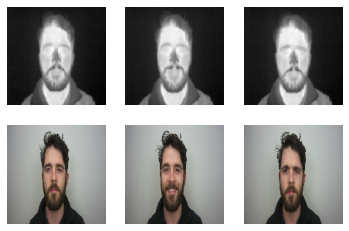

In [ ]:
n_samples = 3
for i in range(n_samples):
  plt.subplot(2, n_samples, 1 + i)
  plt.axis('off')
  plt.imshow(src_train[i].astype('uint8'))

for i in range(n_samples):
  plt.subplot(2, n_samples, 1 + n_samples + i)
  plt.axis('off')
  plt.imshow(tar_train[i].astype('uint8'))
plt.show()

##building the model

In [ ]:
from numpy import load, zeros, ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import RandomNormal

###define discriminator

In [ ]:
def discriminator_model(in_shape=(128, 128, 3)):
  #weights initialization
  init = RandomNormal(stddev=.02)
  #input layers
  in_src_im = Input(shape=in_shape)
  in_tar_im = Input(shape=in_shape)
  #concatenate inputs
  merged = Concatenate()([in_src_im, in_tar_im])

  d = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(merged)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  #patch output
  d = Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(d)
  patch_out = Activation('sigmoid')(d)

  model = Model([in_src_im, in_tar_im], patch_out)
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
  return model

###define generator

####define helper functions for ResUnet architecture

In [ ]:
def encoder_block(n_filters, input_layer, s1=(2, 2), s2=(1, 1) ,batch_norm=True):
  init = RandomNormal(stddev=0.02)
  if batch_norm:
    x = BatchNormalization()(input_layer)
    x = Activation('relu')(x)
    x = Conv2D(n_filters, (3, 3), strides=s1, padding='same', kernel_initializer=init)(x)
  else:
    x = Conv2D(n_filters, (3, 3), strides=s1, padding='same', kernel_initializer=init)(input_layer)

  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(n_filters, (3, 3), strides=s2, padding='same', kernel_initializer=init)(x)
  
  alt = Conv2D(n_filters, (1, 1), strides=s1, padding='same', kernel_initializer=init)(input_layer)
  alt = BatchNormalization()(alt)

  x = Add()([x, alt])
  return x

In [ ]:
def decoder_block(n_filters, input_layer, skip):
  init = RandomNormal(stddev=0.02)
  x = Conv2DTranspose(n_filters, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(input_layer)
  g = Concatenate()([x, skip])
  x = BatchNormalization()(g)
  x = Activation('relu')(x)
  x = Conv2D(n_filters, (3, 3), strides=(1, 1), padding='same', kernel_initializer=init)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(n_filters, (3, 3), strides=(1, 1), padding='same', kernel_initializer=init)(x)

  alt = Conv2D(n_filters, (1, 1), strides=(1, 1), padding='same', kernel_initializer=init)(g)
  alt = BatchNormalization()(alt)

  x = Add()([x, alt])
  return x

In [ ]:
def generator(image_shape=(128, 128, 3)):
  init = RandomNormal(stddev=0.02)
  #encoding
  in_layer = Input(shape=image_shape)
  e1 = encoder_block(64, in_layer, s1=(1, 1), s2=(1, 1) ,batch_norm=False)
  e2 = encoder_block(128, e1)
  e3 = encoder_block(256, e2)

  #bridge
  x = BatchNormalization()(e3)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), strides=(1, 1), padding='same', kernel_initializer=init)(x)

  alt = Conv2D(256, (1, 1), strides=(2, 2), padding='same', kernel_initializer=init)(e3)
  alt = BatchNormalization()(alt)

  x = Add()([alt, x])

  #decoding
  d1 = decoder_block(256, x, e3)
  d2 = decoder_block(128, d1, e2)
  d3 = decoder_block(64, d2, e1)

  #output
  g = Conv2D(3, (1, 1), padding='same', kernel_initializer=init)(d3)
  out_layer = Activation('tanh')(g)
  model = Model(in_layer, out_layer) 
  return model

###define GAN model

In [ ]:
def gan_model(g_model, d_model, image_shape=(128, 128, 3)):
  #marking disc weights as non trainable
  for layer in d_model.layers:
    if not isinstance(layer, BatchNormalization):
      layer.trainable = False
    
  in_src = Input(shape=image_shape)
  gen_out = g_model(in_src)
  disc_out = d_model([in_src, gen_out])
  model = Model(in_src, [disc_out, gen_out])

  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1, 100])
  return model

###helper functions for generating real and fake samples

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
  trainA, trainB = dataset
  ix = randint(0, trainA.shape[0], n_samples)
  X1, X2 = trainA[ix], trainB[ix]
  y = ones((n_samples, patch_shape, patch_shape, 1))
  return [X1, X2], y

In [ ]:
# generate a batch of images, returns images and target
def generate_fake_samples(g_model, samples, patch_shape):
  X = g_model.predict(samples)
  y = zeros((len(X), patch_shape, patch_shape, 1))
  return X, y

In [ ]:
def summarize_performance(step, g_model, d_model, dataset, n_samples=3):
  [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
  X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
  #scale all pixels from [-1, 1] to [0, 1]
  X_realA = (X_realA + 1) / 2.0
  X_realB = (X_realB + 1) / 2.0
  X_fakeB = (X_fakeB + 1) / 2.0
  #plot real source images
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(X_realA[i])
  #plot generated images
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(X_fakeB[i])
  # plot real target image
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + n_samples*2 + i)
    plt.axis('off')
    plt.imshow(X_realB[i])
  plt.show()
  plt.close()
  # save the generator model
  if (step+1) % (900*5) == 0:
    filename2 = 'drive/MyDrive/pix2pix_checks/g_31-35_%06d.h5' % (step+1)
    filename3 = 'drive/MyDrive/pix2pix_checks/d_31-35_%06d.h5' % (step+1)
    g_model.save(filename2)
    d_model.save(filename3)
    print('>Saved')

##train

In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
  n_patch = d_model.output_shape[1]
  trainA, trainB = dataset
  batch_per_epoch = int(len(trainA) / n_batch)
  n_steps = batch_per_epoch * n_epochs
  for i in range(n_steps):
    #select a batch of real samples
    [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
    #generate a batch of fake samples
    X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
    #update discriminator for real samples
    d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
    #update discriminator for generated samples
    d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
    #update generator
    g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
    # summarize performance
    print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
    # summarize model performance every epoch
    if (i+1) % (batch_per_epoch * 1) == 0:
      summarize_performance(i, g_model, d_model, dataset)

In [ ]:
#scaling images pixles into [-1:1]
src_tr = (src_train - 127.5) / 127.5
tar_tr = (tar_train - 127.5) / 127.5

dataset = [src_tr, tar_tr]
print(dataset[0].shape, dataset[1].shape)

image_shape = dataset[0].shape[1:]

disc = discriminator_model(image_shape)
gen = generator(image_shape)

gan = gan_model(gen, disc, image_shape)

(900, 128, 128, 3) (900, 128, 128, 3)


In [ ]:
#training for 76500 steps = n_samples * n_epochs / batch_size 
train(disc, gen, gan, dataset)

##Continue training

In [ ]:
disc = tf.keras.models.load_model('drive/MyDrive/pix2pix_checks/d_31-35_040500.h5')

In [ ]:
gen = tf.keras.models.load_model('drive/MyDrive/pix2pix_checks/g_31-35_040500.h5')

In [ ]:
gan = gan_model(gen, disc)

In [ ]:
src_tr = (src_train - 127.5) / 127.5
tar_tr = (tar_train - 127.5) / 127.5

dataset = [src_tr, tar_tr]

train(disc, gen, gan, dataset)

##Testing generator

In [23]:
#test range is a tuple that represents subject's numbers
def get_test_subjects(test_range):
  inf, sup = test_range[0], test_range[1]
  if not check_indexes(inf, sup):
    raise Exception('Not valid indexes') 
  else:
    vals = [ str(i) for i in range(inf, sup+1)]
    for i in range(len(vals)):
      if len(vals[i]) == 2:
        vals[i] = '0' + vals[i]
      else:
        vals[i] = '00' + vals[i]
    return vals

In [26]:
def load_test_data(data_path, test_subs):
  y = [ os.path.join(data_path, i, 'TH') for i in test_subs]
  im_path = []
  im_name = []
  for x in y:
    for i in os.listdir(x):
      #skipping dark images
      if i.find('20_LD') != -1:
        continue
      else:
        im_path.append(os.path.join(x, i))
        im_name.append(i)
  im_name = [ i.replace('tiff', 'jpg') for i in im_name]
  im_name = [ i.replace('TH', 'VIS') for i in im_name]
  return im_path, im_name

In [47]:
#load, predict and save result
def generate_data(image_path, image_name, res_dir, model):
  for i in range(len(image_path)):
    #read image
    im = load_img(image_path[i], target_size=(128,128)) 
    im = img_to_array(im)
    #scale image tp [-1, 1]
    im = (im - 127.5) / 127.5
    im = np.expand_dims(im, axis=0)
    #predict
    pred = model.predict(im)
    #rescale image to [0, 1]
    pred = (pred + 1) / 2.0
    try:
      tf.keras.preprocessing.image.save_img(res_dir + image_name[i], pred[0], scale=True)
    except:
      print('error saving image please verify the path!')

In [72]:
test_range = (46, 50)

test_subjects = get_test_subjects(test_range)

In [73]:
im_path, im_name = load_test_data(data_path, test_subjects)

In [74]:
#loading saved generator
model = tf.keras.models.load_model('drive/MyDrive/pix2pix_checks/g_46-50_090000.h5', compile=False)


res_dir = 'drive/MyDrive/Summer_internships/Transfert/Results/Translated_dataset/'


generate_data(im_path, im_name, res_dir, model)